# Basic neural net. Practice
# Keras API

Source: 
- https://github.com/Hvass-Labs/TensorFlow-Tutorials
- https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ

## Introduction

This tutorial demonstrates how to build a simple neural network using Keras with Tensorflow backend. After loading the so-called MNIST data-set with images of hand-written digits, we define and optimize a simple mathematical model. The results are then plotted and discussed.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from helpers import *

We need to import several things from Keras. Note the long import-statements. This might be a bug. Hopefully it will be possible to write shorter and more elegant lines in the future.

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Dense, Flatten

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.4.0'

In [4]:
tf.keras.__version__

'2.0.8-tf'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [7]:
data.test.labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [8]:
data.test.labels.shape

(10000, 10)

In [9]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [10]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Plot a few images to see if data is correct

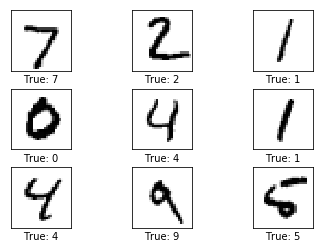

In [11]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, img_shape=img_shape)

## Sequential Model

The Keras API has two modes of constructing Neural Networks. The simplest is the Sequential Model which only allows for the layers to be added in sequence.

In [12]:
# Start construction of the Keras Sequential model.
model = Sequential()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [14]:
# First fully-connected / dense layer
model.add(Dense(128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
Total params: 100,480
Trainable params: 100,480
Non-trainable params: 0
_________________________________________________________________


In [15]:
128*784

100352

In [16]:
# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Model Compilation

The Neural Network has now been defined and must be finalized by adding a loss-function, optimizer and performance metrics. This is called model "compilation" in Keras.

We can either define the optimizer using a string, or if we want more control of its parameters then we need to instantiate an object. For example, we can set the learning-rate.

In [17]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuracy.

In [18]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times.

In [19]:
history = model.fit(x=data.train.images,
          y=data.train.labels, validation_split=0.05,
          epochs=10, batch_size=128)

Train on 52250 samples, validate on 2750 samples
Epoch 1/10
52250/52250 [==============================] - 1s - loss: 0.4130 - acc: 0.8822 - val_loss: 0.2252 - val_acc: 0.9389
Epoch 2/10
52250/52250 [==============================] - 1s - loss: 0.2970 - acc: 0.9172 - val_loss: 0.2060 - val_acc: 0.9433
Epoch 3/10
52250/52250 [==============================] - 1s - loss: 0.2853 - acc: 0.9189 - val_loss: 0.2212 - val_acc: 0.9411
Epoch 4/10
52250/52250 [==============================] - 1s - loss: 0.2773 - acc: 0.9224 - val_loss: 0.2197 - val_acc: 0.9495
Epoch 5/10
52250/52250 [==============================] - 1s - loss: 0.2739 - acc: 0.9233 - val_loss: 0.2113 - val_acc: 0.9422
Epoch 6/10
52250/52250 [==============================] - 1s - loss: 0.2684 - acc: 0.9236 - val_loss: 0.2151 - val_acc: 0.9389
Epoch 7/10
52250/52250 [==============================] - 1s - loss: 0.2653 - acc: 0.9256 - val_loss: 0.2115 - val_acc: 0.9458
Epoch 8/10
52250/52250 [==============================] - 1s -

### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [20]:
result = model.evaluate(x=data.test.images,
                        y=data.test.labels)

 9152/10000 [==========================>...] - ETA: 0s

We can print all the performance metrics for the test-set.

In [21]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.289508258358
acc 0.9228


Or we can just print the classification accuracy.

In [22]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 92.28%


In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])

In [24]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

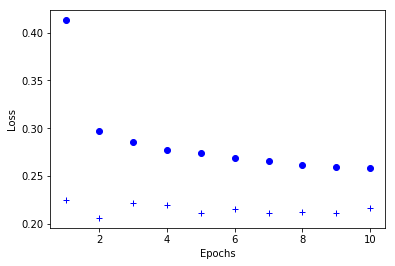

In [25]:
plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

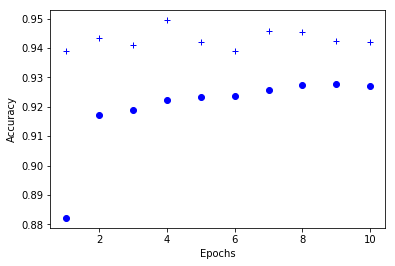

In [26]:
plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [27]:
images = data.test.images[0:9]

These are the true class-number for those images. This is only used when plotting the images.

In [28]:
cls_true = data.test.cls[0:9]

Get the predicted classes as One-Hot encoded arrays.

In [29]:
y_pred = model.predict(x=images)

Get the predicted classes as integers.

In [30]:
cls_pred = np.argmax(y_pred,axis=1)

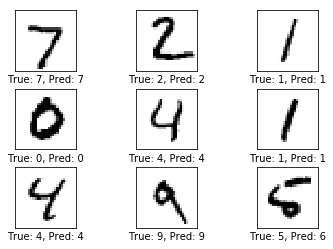

In [31]:
plot_images(images=images,
            img_shape=img_shape,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [32]:
y_pred = model.predict(x=data.test.images)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [33]:
cls_pred = np.argmax(y_pred,axis=1)

Plot some of the mis-classified images.

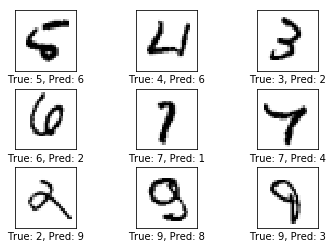

In [34]:
plot_example_errors(images, cls_true, img_shape, cls_pred, data)

## Save & Load Model

NOTE: You need to install `h5py` for this to work.

This is the file-path where we want to save the Keras model.

In [35]:
path_model = 'model.keras'

Saving a Keras model with the trained weights is then just a single function call, as it should be.

In [36]:
model.save(path_model)

Delete the model from memory so we are sure it is no longer used.

In [37]:
del model

We need to import this Keras function for loading the model.

In [38]:
from tensorflow.python.keras.models import load_model

Loading the model is then just a single function-call, as it should be.

In [39]:
model1 = load_model(path_model)

We can then use the model again e.g. to make predictions. We get the first 9 images from the test-set and their true class-numbers.

In [40]:
images = data.test.images[0:9]

In [41]:
cls_true = data.test.cls[0:9]

We then use the restored model to predict the class-numbers for those images.

In [42]:
y_pred = model1.predict(x=images)

Get the class-numbers as integers.

In [43]:
cls_pred = np.argmax(y_pred, axis=1)

Plot the images with their true and predicted class-numbers.

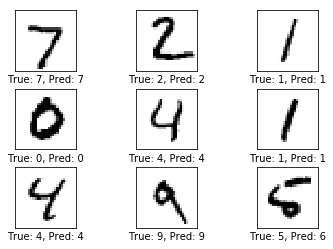

In [44]:
plot_images(images=images,
            img_shape=img_shape,
            cls_pred=cls_pred,
            cls_true=cls_true)